# CMPS 4010
## Milestone 4: Unrealized Volatility Prediction
### By Alex Olteanu and Shira Rozenthal

### Next steps

**COMPLETE**
- Exploratory Data Analysis.

- Reverse Engineer time_ids: Investigate the exact dates and times for each stock and time_id pairing. Integrate with historical data from platforms like Yahoo Finance.

- Began Feature Engineering.

- Configured different models: KNN, Linear regression, Random Forest, Gradient Boosting and SVR.

- Implemented preceding and succeeding realized volatility as engineered features.

**IN PROGRESS**
- K-means Clustering: Determine related time_ids with similar features and use corresponding realized volatilies as engineered features. 

- Finetune existing model hyperparameters.

- Consider ensemble approach.

- Explore time-series sequential models and deep learning approaches. 

### Setup

In [1]:
# %cd /Users/alexolteanu/Desktop/Fall2023/CS Capstone I/Kaggle Data/optiver-realized-volatility-prediction

/Users/alexolteanu/Desktop/Fall2023/CS Capstone I/Kaggle Data/optiver-realized-volatility-prediction


In [2]:
# Standard libraries
import os
import time
import glob
from contextlib import contextmanager

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Parallel processing
from joblib import Parallel, delayed

# Set matplotlib to display inline and pandas option
%matplotlib inline
pd.set_option('display.max_columns', None)

### Tutorial Notebook Imports

In [3]:
# Load and peek train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
# Peek at train data
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [5]:
# Peek at test data
test.head()

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [6]:
# Load and peek book and trade data for stock with id of 0
stock_id = 0

book_example = pd.read_parquet('book_train.parquet/stock_id=0')
trade_example = pd.read_parquet('trade_train.parquet/stock_id=0')

In [7]:
# Peek at book data for stock 0
book_example

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28


In [8]:
# Peek at trade data for stock 0 at time_id 5
book_example[book_example['time_id'] == 5]

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3
298,5,586,1.003129,1.003749,1.002612,1.003801,100,3,2,3
299,5,587,1.003129,1.003749,1.003025,1.003801,100,3,26,3
300,5,588,1.003129,1.003749,1.002612,1.003801,100,3,2,3


In [9]:
# Peek at trade data for stock 0 at time_id 5
trade_example.head()

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


In [10]:
book_example = book_example[book_example['time_id']==5]
book_example.loc[:,'stock_id'] = stock_id

trade_example = trade_example[trade_example['time_id']==5]
trade_example.loc[:,'stock_id'] = stock_id

/var/folders/g2/qbz891654sj8hstpjwf0pr7r0000gn/T/ipykernel_8068/3145531509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_example.loc[:,'stock_id'] = stock_id


In [11]:
book_example.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [12]:
trade_example.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


In [13]:
# Generate a WAP feature for example book df
book_example['wap'] = (book_example['bid_price1'] * book_example['ask_size1'] +
                                book_example['ask_price1'] * book_example['bid_size1']) / (
                                       book_example['bid_size1']+ book_example['ask_size1'])

/var/folders/g2/qbz891654sj8hstpjwf0pr7r0000gn/T/ipykernel_8068/3048661378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_example['wap'] = (book_example['bid_price1'] * book_example['ask_size1'] +


In [14]:
# Plot WAP values for each second interval/observation in time bucket 5
fig = px.line(book_example, x="seconds_in_bucket", y="wap", title='WAP of stock_id_0, time_id_5')
fig.show()

In [15]:
# Define function for computing log returns
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

In [16]:
# Generate a log return feature for example book df
# Takes the log return of row x and row x-1
# Row zero omitted because it cannot be compared to a previous time entry using ~ operator
book_example.loc[:,'log_return'] = log_return(book_example['wap'])
book_example = book_example[~book_example['log_return'].isnull()]

/var/folders/g2/qbz891654sj8hstpjwf0pr7r0000gn/T/ipykernel_8068/2999684887.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
# Plot log returns for each second interval/observation in time bucket 5
fig = px.line(book_example, x="seconds_in_bucket", y="log_return", title='Log return of stock_id_0, time_id_5')
fig.show()

In [18]:
# Define a function to compute realized volatility using the log returns in a time bucket
# Computed by taking the square root of the sum of squared log returns
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

realized_vol = realized_volatility(book_example['log_return'])
print(f'Realized volatility for stock_id 0 on time_id 5 is {realized_vol}')

Realized volatility for stock_id 0 on time_id 5 is 0.004499364172786558


In [19]:
# Create a list of all file paths within book training parquet file
list_order_book_file_train = glob.glob('book_train.parquet/*')

list_order_book_file_train

['book_train.parquet/stock_id=17',
 'book_train.parquet/stock_id=28',
 'book_train.parquet/stock_id=10',
 'book_train.parquet/stock_id=26',
 'book_train.parquet/stock_id=19',
 'book_train.parquet/stock_id=21',
 'book_train.parquet/stock_id=75',
 'book_train.parquet/stock_id=81',
 'book_train.parquet/stock_id=86',
 'book_train.parquet/stock_id=72',
 'book_train.parquet/stock_id=44',
 'book_train.parquet/stock_id=88',
 'book_train.parquet/stock_id=43',
 'book_train.parquet/stock_id=20',
 'book_train.parquet/stock_id=27',
 'book_train.parquet/stock_id=18',
 'book_train.parquet/stock_id=11',
 'book_train.parquet/stock_id=16',
 'book_train.parquet/stock_id=29',
 'book_train.parquet/stock_id=89',
 'book_train.parquet/stock_id=42',
 'book_train.parquet/stock_id=73',
 'book_train.parquet/stock_id=87',
 'book_train.parquet/stock_id=80',
 'book_train.parquet/stock_id=74',
 'book_train.parquet/stock_id=103',
 'book_train.parquet/stock_id=104',
 'book_train.parquet/stock_id=105',
 'book_train.parq

In [20]:
# Define a function for computing the realitized volatiltiy for each time bucket for a specific stock
def realized_volatility_per_time_id(file_path, prediction_column_name):
    # Load the parquet file for a specific stock into a DataFrame
    df_book_data = pd.read_parquet(file_path)

    # Compute the Weighted Average Price (WAP) using bid and ask prices and sizes
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
                                      df_book_data['bid_size1']+ df_book_data['ask_size1'])

    # Calculate the log returns of WAP for each 'time_id'
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)

    # Remove rows with NaN values in the 'log_return' column
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]

    # Compute the realized volatility for each 'time_id' based on the log returns
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()

    # Rename the 'log_return' column to the provided prediction_column_name
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})

    # Extract the stock_id from the file_path
    stock_id = file_path.split('=')[1]

    # Create a 'row_id' column combining the stock_id and time_id
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')


    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

In [21]:
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    # Initialize an empty DataFrame to store the results for all stocks
    df_past_realized = pd.DataFrame()

    # Loop through each file in the provided list (each file corresponds to a stock's data)
    for file in list_file:
        # Compute the realized volatility for the current stock using the function 'realized_volatility_per_time_id'
        # This function returns the realized volatility for each 'time_id' of the current stock
        df_single_stock_realized_vol = realized_volatility_per_time_id(file, prediction_column_name)

        # Concatenate the results for the current stock with the aggregated results
        df_past_realized = pd.concat([df_past_realized, df_single_stock_realized_vol])

    # Return the aggregated results for all stocks
    return df_past_realized

# Calculate the realized volatility for all stocks in the training data
# The list 'list_order_book_file_train' contains file paths for all stocks in the training set
df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train, prediction_column_name='pred')

/var/folders/g2/qbz891654sj8hstpjwf0pr7r0000gn/T/ipykernel_8068/2847307796.py:11: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

/var/folders/g2/qbz891654sj8hstpjwf0pr7r0000gn/T/ipykernel_8068/2847307796.py:11: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)

/var/folders/g2/qbz891654sj8hstpjwf0pr7r

In [22]:
df_past_realized_train.head()

,row_id,pred
0,17-5,0.004091
1,17-11,0.002155
2,17-16,0.002566
3,17-31,0.002221
4,17-62,0.002155


In [23]:
train

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


In [24]:
# Create a new column 'row_id' in the 'train' dataframe. This column is a combination of the 'stock_id' and 'time_id' columns.
# The two values are separated by a '-' and both are converted to string type to facilitate concatenation.
train_mod = pd.read_csv('train.csv')

train_mod['row_id'] = train['stock_id'].astype(str) + '-' + train_mod['time_id'].astype(str)

# Update the 'train' dataframe to keep only the 'row_id' and 'target' columns.
train_mod = train_mod[['row_id','target']]

# Merge the 'train' dataframe with the 'df_past_realized_train' dataframe.
# The merging is based on the 'row_id' column, which is common between the two dataframes.
# This is a left merge, which means all the rows from the 'train' dataframe will be retained and corresponding
# values from 'df_past_realized_train' will be added wherever there's a match based on 'row_id'.
# If there's no match for a particular 'row_id' in 'df_past_realized_train', NaN values will be filled for 'pred' column.
df_joined = train_mod.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'left')

In [25]:
train_mod

,row_id,target
0,0-5,0.004136
1,0-11,0.001445
2,0-16,0.002168
3,0-31,0.002195
4,0-62,0.001747
...,...,...
428927,126-32751,0.003461
428928,126-32753,0.003113
428929,126-32758,0.004070
428930,126-32763,0.003357


In [26]:
df_joined

,row_id,target,pred
0,0-5,0.004136,0.004499
1,0-11,0.001445,0.001204
2,0-16,0.002168,0.002369
3,0-31,0.002195,0.002574
4,0-62,0.001747,0.001894
...,...,...,...
428927,126-32751,0.003461,0.003691
428928,126-32753,0.003113,0.004104
428929,126-32758,0.004070,0.003118
428930,126-32763,0.003357,0.003661


In [27]:
from sklearn.metrics import r2_score

# Define a function to calculate the Root Mean Squared Percentage Error (RMSPE)
def rmspe(y_true, y_pred):
    # The formula for RMSPE is the square root of the average of squared percentage errors.
    # The percentage error is calculated as (actual - predicted) / actual, squared to penalize larger errors.
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

# Calculate the R^2 score using the true target values and the predicted values from the 'df_joined' dataframe.
# The R^2 score measures the proportion of the variance in the dependent variable that is predictable from the independent variables.
# It provides a measure of how well the observed outcomes are replicated by the model.
R2 = round(r2_score(y_true = df_joined['target'], y_pred = df_joined['pred']),3)

# Calculate the RMSPE using the true target values and the predicted values from the 'df_joined' dataframe.
RMSPE = round(rmspe(y_true = df_joined['target'], y_pred = df_joined['pred']),3)

# Print out the calculated R^2 score and RMSPE.
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the naive prediction: R2 score: 0.628, RMSPE: 0.341


### EDA

In [28]:
# Define functions for readily extracting layers of the parquet file
def read_parquet_file(data_type, stock_id):
    file_path = f'{data_type}_train.parquet/stock_id={stock_id}'
    return pd.read_parquet(file_path)

def filter_data(df, time_id=None, seconds_in_bucket=None):
    if time_id:
        df = df[df['time_id'] == time_id]
    if seconds_in_bucket:
        df = df[df['seconds_in_bucket'] == seconds_in_bucket]
    return df

def extract_data(data_type, stock_id, time_id=None, seconds_in_bucket=None):
    if data_type not in ['book', 'trade']:
        raise ValueError("data_type should be either 'book' or 'trade'")

    df = read_parquet_file(data_type, stock_id)

    df = filter_data(df, time_id, seconds_in_bucket)

    return df

In [29]:
df_book_test = extract_data('book', 1, 5, 10)
#df_book_test

df_book_test2 = extract_data('book', 1, 5)
#df_book_test2

df_book_test3 = extract_data('book', 1)
#df_book_test3

df_trade_test = extract_data('trade', 1, 5, 28)
#df_trade_test

df_trade_test2 = extract_data('trade', 1, 5)
#df_trade_test2

df_trade_test3 = extract_data('trade', 1)
#df_trade_test3

In [30]:
stock_ids = sorted([file.split('=')[-1] for file in list_order_book_file_train], key=int)

print(f"Number of unique stocks: {len(stock_ids)}")
print(f"Stock ids: {stock_ids}")

Number of unique stocks: 112
Stock ids: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '46', '47', '48', '50', '51', '52', '53', '55', '56', '58', '59', '60', '61', '62', '63', '64', '66', '67', '68', '69', '70', '72', '73', '74', '75', '76', '77', '78', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '118', '119', '120', '122', '123', '124', '125', '126']


In [31]:
sample_data = read_parquet_file('book', 90)

In [32]:
unique_time_ids = sample_data['time_id'].unique()
print(f"\nNumber of unique time ids: {len(unique_time_ids)}")
print(f"Unique time ids: {unique_time_ids}")


Number of unique time ids: 3830
Unique time ids: [    5    11    16 ... 32758 32763 32767]


In [33]:
unique_seconds = sample_data['seconds_in_bucket'].unique()
print(f"\nNumber of unique seconds in a time bucket: {len(unique_seconds)}")
print(f"Unique seconds values: {sorted(unique_seconds)}")


Number of unique seconds in a time bucket: 600
Unique seconds values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207

In [34]:
consistent_time_ids = True
consistent_seconds = True

for stock_id in stock_ids[1:10]:
    data = read_parquet_file('book', stock_id)

    if not set(unique_time_ids) == set(data['time_id'].unique()):
        consistent_time_ids = False

    if not set(unique_seconds) == set(data['seconds_in_bucket'].unique()):
        consistent_seconds = False

    if not (consistent_time_ids and consistent_seconds):
        break

print(f"\nTime ids are consistent across stocks: {consistent_time_ids}")
print(f"Seconds in bucket values are consistent across stocks: {consistent_seconds}")


Time ids are consistent across stocks: True
Seconds in bucket values are consistent across stocks: True


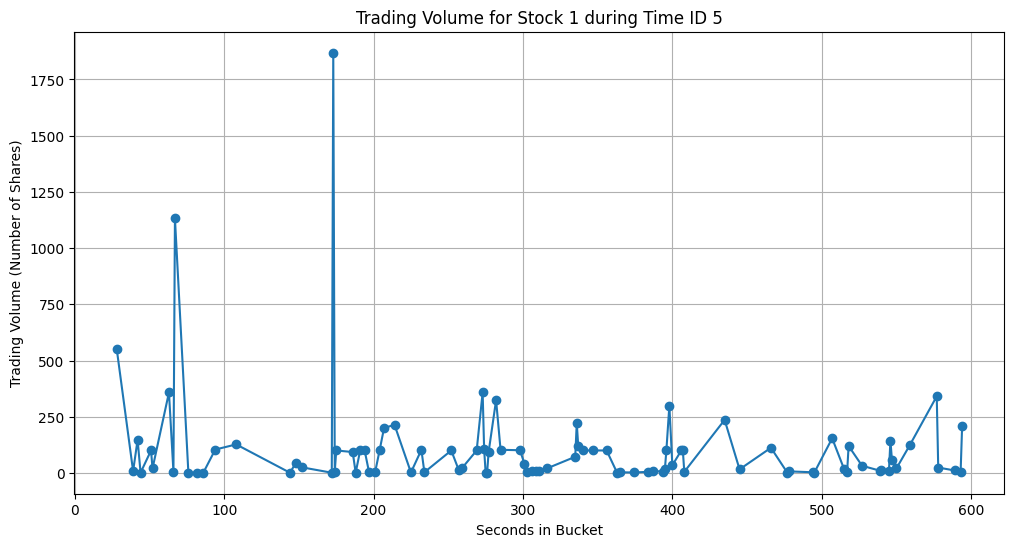

In [35]:
def plot_trading_volume(stock_id, time_id):
    trade_data = extract_data(data_type='trade', stock_id=stock_id)

    trade_data_time_id = trade_data[trade_data['time_id'] == time_id]

    plt.figure(figsize=(12, 6))
    plt.plot(trade_data_time_id['seconds_in_bucket'], trade_data_time_id['size'], marker='o', linestyle='-')
    plt.title(f'Trading Volume for Stock {stock_id} during Time ID {time_id}')
    plt.xlabel('Seconds in Bucket')
    plt.ylabel('Trading Volume (Number of Shares)')
    plt.grid(True)
    plt.show()

plot_trading_volume(stock_id=1, time_id=5)

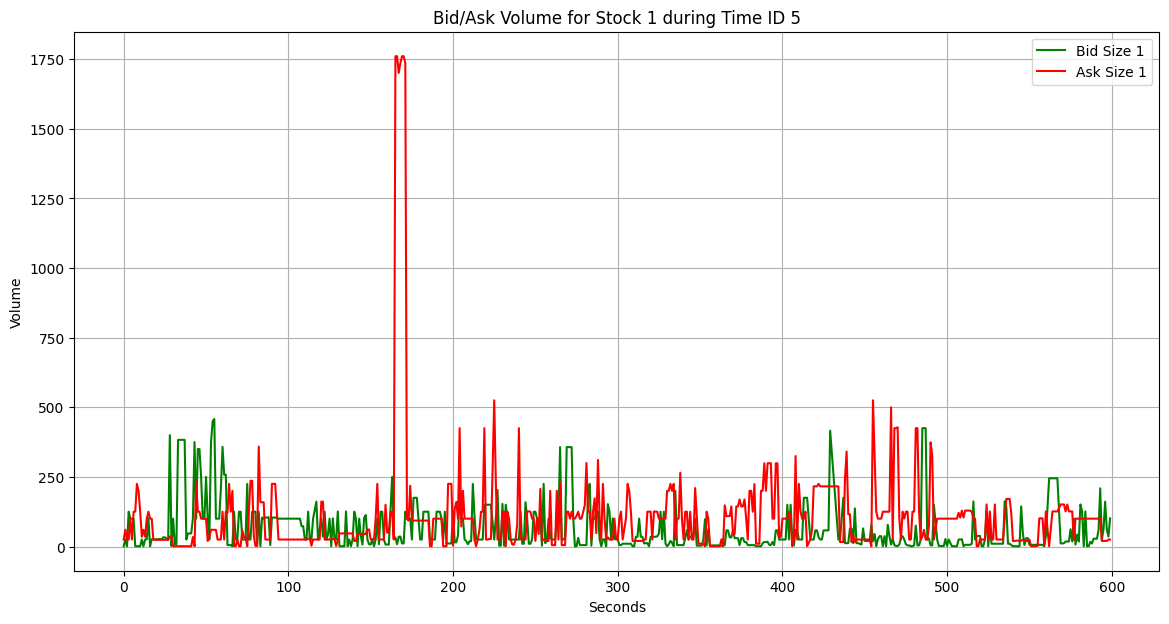

In [36]:
def plot_bid_ask_volume(stock_id, time_id):
    book_data = extract_data('book', stock_id, time_id)

    plt.figure(figsize=(14, 7))
    plt.plot(book_data['seconds_in_bucket'], book_data['bid_size1'], label='Bid Size 1', color='green')
    plt.plot(book_data['seconds_in_bucket'], book_data['ask_size1'], label='Ask Size 1', color='red')

    plt.title(f'Bid/Ask Volume for Stock {stock_id} during Time ID {time_id}')
    plt.xlabel('Seconds')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_bid_ask_volume(stock_id=1, time_id=5)

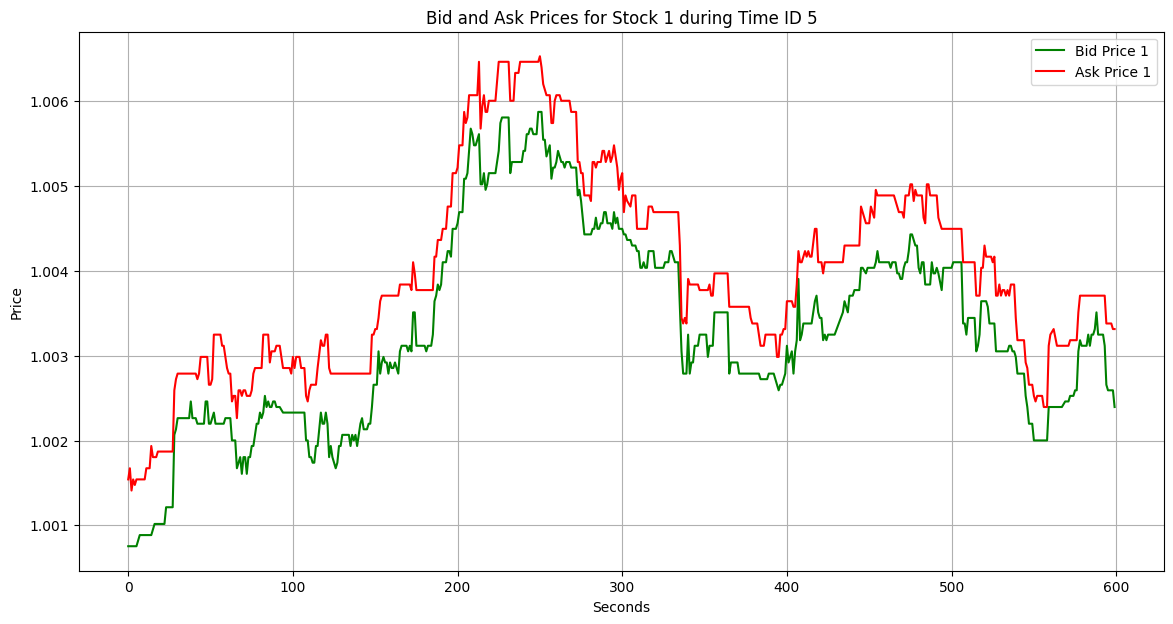

In [37]:
def plot_bid_ask_price(stock_id, time_id):
    book_data = extract_data('book', stock_id, time_id)

    plt.figure(figsize=(14, 7))

    plt.plot(book_data['seconds_in_bucket'], book_data['bid_price1'], label='Bid Price 1', color='green')
    plt.plot(book_data['seconds_in_bucket'], book_data['ask_price1'], label='Ask Price 1', color='red')

    plt.title(f'Bid and Ask Prices for Stock {stock_id} during Time ID {time_id}')
    plt.xlabel('Seconds')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_bid_ask_price(stock_id=1, time_id=5)

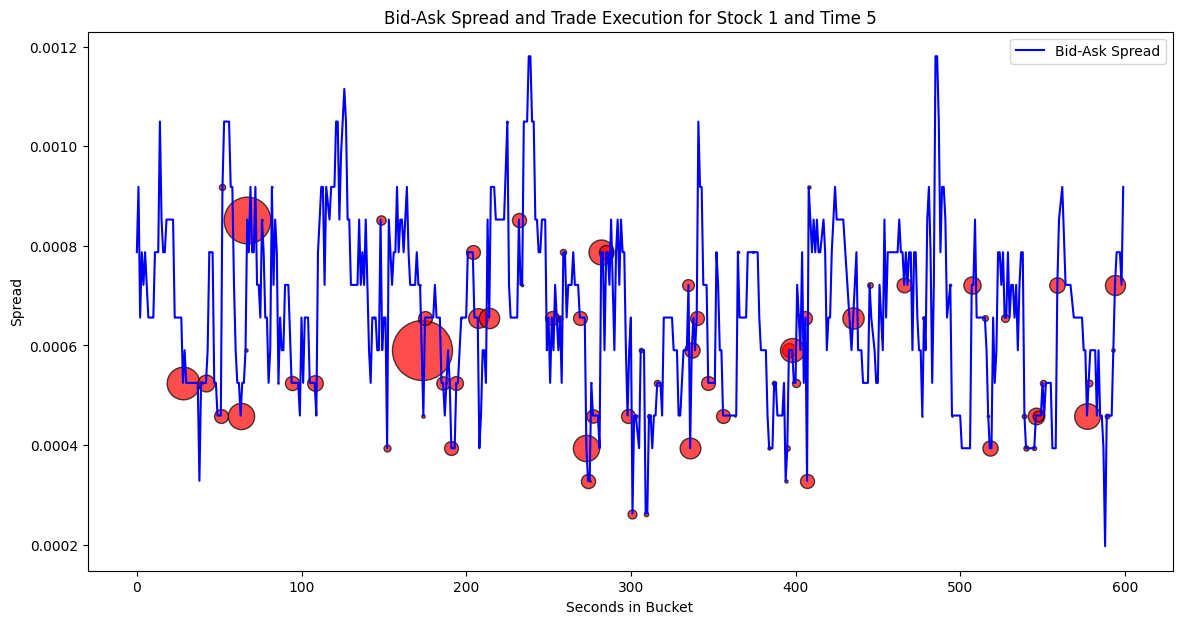

In [38]:
def visualize_spread_and_trades(stock_id, time_id):
    book_data = extract_data('book', stock_id, time_id)
    trade_data = extract_data('trade', stock_id, time_id)

    book_data['spread'] = book_data['ask_price1'] - book_data['bid_price1']

    plt.figure(figsize=(14, 7))
    plt.plot(book_data['seconds_in_bucket'], book_data['spread'], label='Bid-Ask Spread', color='blue')

    for _, row in trade_data.iterrows():
        color = 'red' if row['price'] > book_data.loc[book_data['seconds_in_bucket'] == row['seconds_in_bucket'], 'bid_price1'].values[0] else 'green'
        plt.scatter(row['seconds_in_bucket'], book_data.loc[book_data['seconds_in_bucket'] == row['seconds_in_bucket'], 'spread'].values[0],
                    s=row['size'],
                    color=color,
                    edgecolors='black',
                    alpha=0.7)

    plt.title(f'Bid-Ask Spread and Trade Execution for Stock {stock_id} and Time {time_id}')
    plt.xlabel('Seconds in Bucket')
    plt.ylabel('Spread')
    plt.legend()
    plt.show()

visualize_spread_and_trades(1, 5)

### Reversing Time-ID order

In [39]:
@contextmanager
def timer(name):
    s = time.time()
    yield
    e = time.time() - s
    print(f"[{name}] {e:.3f}sec")


def calc_price2(df):
    tick = sorted(np.diff(sorted(np.unique(df.values.flatten()))))[0]
    return 0.01 / tick


def calc_prices(r):
    df = pd.read_parquet(r.book_path, columns=['time_id', 'ask_price1', 'ask_price2', 'bid_price1', 'bid_price2'])
    df = df.set_index('time_id')
    df = df.groupby(level='time_id').apply(calc_price2).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df


def sort_manifold(df, clf):
    df_ = df.set_index('time_id')
    df_ = pd.DataFrame(minmax_scale(df_.fillna(df_.mean())))

    X_compoents = clf.fit_transform(df_)

    dft = df.reindex(np.argsort(X_compoents[:,0])).reset_index(drop=True)
    return np.argsort(X_compoents[:, 0]), X_compoents


def reconstruct_time_id_order():
    with timer('load files'):
        df_files = pd.DataFrame(
            {'book_path': glob.glob('book_train.parquet/**/*.parquet')}) \
            .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")', engine='python')

    with timer('calc prices'):
        df_prices = pd.concat(Parallel(n_jobs=4, verbose=51)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))
        df_prices = df_prices.pivot('time_id', 'stock_id', 'price')
        df_prices.columns = [f'stock_id={i}' for i in df_prices.columns]
        df_prices = df_prices.reset_index(drop=False)

    with timer('t-SNE(400) -> 50'):
        clf = TSNE(n_components=1, perplexity=400, random_state=0, n_iter=2000)
        order, X_compoents = sort_manifold(df_prices, clf)

        clf = TSNE(n_components=1, perplexity=50, random_state=0, init=X_compoents, n_iter=2000, method='exact')
        order, X_compoents = sort_manifold(df_prices, clf)

        df_ordered = df_prices.reindex(order).reset_index(drop=True)
        if df_ordered['stock_id=61'].iloc[0] > df_ordered['stock_id=61'].iloc[-1]:
            df_ordered = df_ordered.reindex(df_ordered.index[::-1]).reset_index(drop=True)

    # AMZN
    plt.plot(df_ordered['stock_id=61'])

    return df_ordered[['time_id']]

<>:36: SyntaxWarning:

invalid escape sequence '\d'

<>:36: SyntaxWarning:

invalid escape sequence '\d'

/var/folders/g2/qbz891654sj8hstpjwf0pr7r0000gn/T/ipykernel_8068/3674737038.py:36: SyntaxWarning:

invalid escape sequence '\d'



[load files] 0.013sec
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


<unknown>:1: SyntaxWarning:

invalid escape sequence '\d'



[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  16 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Do

/var/folders/g2/qbz891654sj8hstpjwf0pr7r0000gn/T/ipykernel_8068/3674737038.py:40: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



[t-SNE(400) -> 50] 476.289sec


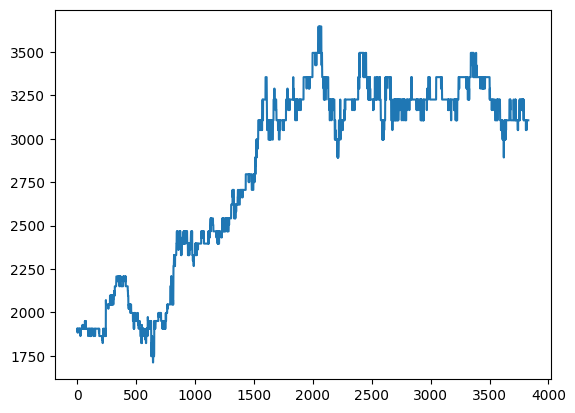

In [40]:
df_ordered = reconstruct_time_id_order()

In [41]:
df_ordered

,time_id
0,4294
1,24033
2,5666
3,29740
4,22178
...,...
3825,24913
3826,32195
3827,15365
3828,10890


### Feature Engineering

#### Neighboring Volatility Features

In [42]:
# Create a list of all file paths within book training parquet file
list_order_book_file_train = glob.glob('book_train.parquet/*')

# Create a list of all file paths within trade training parquet file
list_order_trade_file_train = glob.glob('trade_train.parquet/*')

In [43]:
master = df_joined
master = master.rename(columns={'pred': 'realized_vol'})
master

,row_id,target,realized_vol
0,0-5,0.004136,0.004499
1,0-11,0.001445,0.001204
2,0-16,0.002168,0.002369
3,0-31,0.002195,0.002574
4,0-62,0.001747,0.001894
...,...,...,...
428927,126-32751,0.003461,0.003691
428928,126-32753,0.003113,0.004104
428929,126-32758,0.004070,0.003118
428930,126-32763,0.003357,0.003661


In [44]:
train

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


In [45]:
df_ordered

,time_id
0,4294
1,24033
2,5666
3,29740
4,22178
...,...
3825,24913
3826,32195
3827,15365
3828,10890


In [46]:
# Set the 'order' column of df_ordered to be its index values
df_ordered['order'] = df_ordered.index 

In [47]:
# Merge 'train' DataFrame with 'df_ordered' based on the 'time_id' column
# This is a left join, which means all rows from 'train' will be kept, 
# along with matched rows from 'df_ordered'
merged_df = pd.merge(train, df_ordered, on='time_id', how='left')

# Sort the merged DataFrame first by 'stock_id' and then by 'order'
merged_df.sort_values(by=['stock_id', 'order'], inplace=True)

# Create a new 'row_id' column by concatenating 'stock_id' and 'time_id' as strings
merged_df['row_id'] = merged_df['stock_id'].astype(str) + '-' + merged_df['time_id'].astype(str)

# Reorder columns so that 'row_id' is the first column, and retain all other columns
cols = ['row_id'] + [col for col in merged_df.columns if col != 'row_id']
df_merged = merged_df[cols]

# Drop 'stock_id' and 'time_id' columns from the DataFrame
df_merged = df_merged.drop(['stock_id', 'time_id'], axis=1)

# Swap the positions of the second and third columns in the DataFrame
cols = df_merged.columns.tolist()
cols[1], cols[2] = cols[2], cols[1]
df_merged = df_merged[cols]

In [48]:
# Merge 'master' DataFrame with 'df_merged' on 'row_id', using a right join
# This keeps all rows from 'df_merged' and the matched rows from 'master'
master = master.merge(df_merged, on='row_id', how='right')

# Rename the column 'target_x' to 'target' in the 'master' DataFrame
master = master.rename(columns={'target_x': 'target'})

# Drop the column 'target_y' from the 'master' DataFrame
master = master.drop(['target_y'], axis=1)

# Select and reorder specific columns in the 'master' DataFrame
master = master[['row_id', 'order', 'target', 'realized_vol']]

# Extract the stock identifier from 'row_id' and create a new column 'stock'
master['stock'] = master['row_id'].str.split('-').str[0]

# Create 'previous_vol' column by shifting 'realized_vol' down within each stock group
master['previous_vol'] = master.groupby('stock')['realized_vol'].shift(1)

# Replace NaN in 'previous_vol' with the corresponding 'realized_vol' values
master['previous_vol'].fillna(master['realized_vol'], inplace=True)

# Create 'next_vol' column by shifting 'realized_vol' up within each stock group
master['next_vol'] = master.groupby('stock')['realized_vol'].shift(-1)

# Replace NaN in 'next_vol' with the corresponding 'realized_vol' values
master['next_vol'].fillna(master['realized_vol'], inplace=True)

# Finalize the DataFrame by selecting specific columns
master = master[['row_id', 'order', 'target', 'realized_vol', 'previous_vol', 'next_vol']]


In [ ]:
master = master.merge(df_merged, on='row_id', how='right')

master = master.rename(columns={'target_x': 'target'})

master = master.drop(['target_y'], axis=1)

master = master[['row_id', 'order', 'target', 'realized_vol']]

master['stock'] = master['row_id'].str.split('-').str[0]

master['previous_vol'] = master.groupby('stock')['realized_vol'].shift(1)

master['previous_vol'].fillna(master['realized_vol'], inplace=True)

master['next_vol'] = master.groupby('stock')['realized_vol'].shift(-1)

master['next_vol'].fillna(master['realized_vol'], inplace=True)

master = master[['row_id', 'order', 'target', 'realized_vol', 'previous_vol', 'next_vol']]

In [77]:
master_vols = master[['row_id', 'order', 'target', 'realized_vol', 'previous_vol', 'next_vol']]
master_vols

,row_id,order,target,realized_vol,previous_vol,next_vol
0,0-4294,0,0.003267,0.007026,0.007026,0.004136
1,0-24033,1,0.002580,0.004136,0.007026,0.002395
2,0-5666,2,0.002051,0.002395,0.004136,0.001790
3,0-29740,3,0.002364,0.001790,0.002395,0.002601
4,0-22178,4,0.001439,0.002601,0.001790,0.001465
...,...,...,...,...,...,...
428927,126-24913,3825,0.006360,0.007303,0.006111,0.006109
428928,126-32195,3826,0.005479,0.006109,0.007303,0.005740
428929,126-15365,3827,0.004802,0.005740,0.006109,0.004815
428930,126-10890,3828,0.006899,0.004815,0.005740,0.004781


#### Aggregated Time Bucket Features

In [50]:
def book_aggregate_features_per_time_id(file_path, feature_aggregations):
    df_book_data = pd.read_parquet(file_path)
    stock_id = int(file_path.split('=')[1])

    # Prepare aggregation
    aggregation_dict = {}
    for new_name, (original, agg_func) in feature_aggregations.items():
        aggregation_dict.setdefault(original, []).append((new_name, agg_func))

    # Aggregate features
    df_aggregated = df_book_data.groupby('time_id').agg(
        {key: [func for _, func in value] for key, value in aggregation_dict.items()}
    )

    # Simplify MultiIndex in columns
    df_aggregated.columns = [
        f"{original}_{agg_func.__name__ if callable(agg_func) else agg_func}"
        for original, funcs in aggregation_dict.items() for _, agg_func in funcs
    ]

    # Efficient row_id creation
    df_aggregated['row_id'] = f"{stock_id}-" + df_aggregated.index.astype(str)
    df_aggregated.reset_index(drop=True, inplace=True)

    # Reorder columns
    cols = ['row_id'] + [col for col in df_aggregated.columns if col != 'row_id']
    df_aggregated = df_aggregated[cols]

    return df_aggregated

def book_aggregate_features_for_all_stocks(list_file, feature_aggregations):
    aggregated_data = [book_aggregate_features_per_time_id(file, feature_aggregations) for file in list_file]
    return pd.concat(aggregated_data, ignore_index=True)

def append_book_flattened_feature(list_file, flattened_feature, master):
    df_aggregated_book = book_aggregate_features_for_all_stocks(list_file, flattened_feature)
    master = pd.merge(master, df_aggregated_book, on='row_id', how='left')
    return master


In [53]:
def trade_aggregate_features_per_time_id(file_path, feature_aggregations):
    df_trade_data = pd.read_parquet(file_path)
    stock_id = int(file_path.split('=')[1])

    # Prepare the aggregation dictionary
    aggregation_dict = {}
    for new_name, (original, agg_func) in feature_aggregations.items():
        aggregation_dict.setdefault(original, []).append((new_name, agg_func))

    # Aggregate features
    df_aggregated = df_trade_data.groupby('time_id').agg(
        {key: [func for _, func in value] for key, value in aggregation_dict.items()}
    )

    # Simplify MultiIndex in columns
    df_aggregated.columns = [
        f"{original}_{agg_func.__name__ if callable(agg_func) else agg_func}"
        for original, funcs in aggregation_dict.items() for _, agg_func in funcs
    ]

    # Efficient row_id creation
    df_aggregated['row_id'] = f"{stock_id}-" + df_aggregated.index.astype(str)
    df_aggregated.reset_index(drop=True, inplace=True)

    # Reorder columns
    cols = ['row_id'] + [col for col in df_aggregated.columns if col != 'row_id']
    df_aggregated = df_aggregated[cols]

    return df_aggregated

def trade_aggregate_features_for_all_stocks(list_file, feature_aggregations):
    aggregated_data = [trade_aggregate_features_per_time_id(file, feature_aggregations) for file in list_file]
    return pd.concat(aggregated_data, ignore_index=True)

def append_trade_flattened_feature(list_file, flattened_feature, master):
    df_aggregated_trade = trade_aggregate_features_for_all_stocks(list_file, flattened_feature)
    master = pd.merge(master, df_aggregated_trade, on='row_id', how='left')
    return master


In [54]:
def calculate_percent_change(series):
    return (series.iloc[-1] - series.iloc[0]) / series.iloc[0] if series.iloc[0] != 0 else np.nan

def calculate_percent_change_from_extremes(series):
    return (series.max() - series.min()) / series.min() if series.min() != 0 else np.nan

trade_aggregations = {
    'mean_price': ('price', 'mean'),
    'mean_size': ('size', 'mean'),
    'mean_order_count': ('order_count', 'mean'),

    'min_price': ('price', 'min'),
    'min_size': ('size', 'min'),
    'min_order_count': ('order_count', 'min'),

    'max_price': ('price', 'max'),
    'max_size': ('size', 'max'),
    'max_order_count': ('order_count', 'max'),

    'range_price': ('price', np.ptp),
    'range_size': ('size', np.ptp),
    'range_order_count': ('order_count', np.ptp),

    'percent_change_price': ('price', calculate_percent_change),
    'percent_change_size': ('size', calculate_percent_change),
    'percent_change_order_count': ('order_count', calculate_percent_change),

    'percent_change_extremes_price': ('price', calculate_percent_change_from_extremes),
    'percent_change_extremes_size': ('size', calculate_percent_change_from_extremes),
    'percent_change_extremes_order_count': ('order_count', calculate_percent_change_from_extremes)
}

master = append_trade_flattened_feature(list_order_trade_file_train, trade_aggregations, master)

In [55]:
book_aggregations = {
    'mean_bid_price1': ('bid_price1', 'mean'),
    'mean_ask_price1': ('ask_price1', 'mean'),
    'mean_bid_price2': ('bid_price2', 'mean'),
    'mean_ask_price2': ('ask_price2', 'mean'),
    'mean_bid_size1': ('bid_size1', 'mean'),
    'mean_ask_size1': ('ask_size1', 'mean'),
    'mean_bid_size2': ('bid_size2', 'mean'),
    'mean_ask_size2': ('ask_size2', 'mean'),

    'min_bid_price1': ('bid_price1', 'min'),
    'min_ask_price1': ('ask_price1', 'min'),
    'min_bid_price2': ('bid_price2', 'min'),
    'min_ask_price2': ('ask_price2', 'min'),
    'min_bid_size1': ('bid_size1', 'min'),
    'min_ask_size1': ('ask_size1', 'min'),
    'min_bid_size2': ('bid_size2', 'min'),
    'min_ask_size2': ('ask_size2', 'min'),

    'max_bid_price1': ('bid_price1', 'max'),
    'max_ask_price1': ('ask_price1', 'max'),
    'max_bid_price2': ('bid_price2', 'max'),
    'max_ask_price2': ('ask_price2', 'max'),
    'max_bid_size1': ('bid_size1', 'max'),
    'max_ask_size1': ('ask_size1', 'max'),
    'max_bid_size2': ('bid_size2', 'max'),
    'max_ask_size2': ('ask_size2', 'max'),

    'range_bid_price1': ('bid_price1', np.ptp),
    'range_ask_price1': ('ask_price1', np.ptp),
    'range_bid_price2': ('bid_price2', np.ptp),
    'range_ask_price2': ('ask_price2', np.ptp),
    'range_bid_size1': ('bid_size1', np.ptp),
    'range_ask_size1': ('ask_size1', np.ptp),
    'range_bid_size2': ('bid_size2', np.ptp),
    'range_ask_size2': ('ask_size2', np.ptp),
    
    'percent_change_bid_price1': ('bid_price1', calculate_percent_change),
    'percent_change_ask_price1': ('ask_price1', calculate_percent_change),
    'percent_change_bid_price2': ('bid_price2', calculate_percent_change),
    'percent_change_ask_price2': ('ask_price2', calculate_percent_change),
    'percent_change_bid_size1': ('bid_size1', calculate_percent_change),
    'percent_change_ask_size1': ('ask_size1', calculate_percent_change),
    'percent_change_bid_size2': ('bid_size2', calculate_percent_change),
    'percent_change_ask_size2': ('ask_size2', calculate_percent_change),

    'percent_change_extremes_bid_price1': ('bid_price1', calculate_percent_change_from_extremes),
    'percent_change_extremes_ask_price1': ('ask_price1', calculate_percent_change_from_extremes),
    'percent_change_extremes_bid_price2': ('bid_price2', calculate_percent_change_from_extremes),
    'percent_change_extremes_ask_price2': ('ask_price2', calculate_percent_change_from_extremes),
    'percent_change_extremes_bid_size1': ('bid_size1', calculate_percent_change_from_extremes),
    'percent_change_extremes_ask_size1': ('ask_size1', calculate_percent_change_from_extremes),
    'percent_change_extremes_bid_size2': ('bid_size2', calculate_percent_change_from_extremes),
    'percent_change_extremes_ask_size2': ('ask_size2', calculate_percent_change_from_extremes)
}

master = append_book_flattened_feature(list_order_book_file_train, book_aggregations, master)

#### Pre-Model Processing

In [56]:
missing_values_count = master.isnull().sum()
rows_with_missing_values = master[master.isnull().any(axis=1)]
master = master.dropna()

In [57]:
# Filter out non-numeric columns (excluding 'target' for correlation calculation)
numeric_cols = master.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('target')  # Remove 'target' from the list to avoid self-correlation

# Calculate correlations with the 'target' feature directly
target_correlations = master[numeric_cols].apply(lambda x: x.corr(master['target']))

# Sort the correlations
sorted_correlations = target_correlations.sort_values(ascending=False)

# Print most positively and negatively correlated features
print("Most Positively Correlated Features with 'target':")
print(sorted_correlations.head())  # Adjust the number as needed

print("\nMost Negatively Correlated Features with 'target':")
print(sorted_correlations.tail())  # Adjust the number as needed

# Convert the sorted correlations series to a DataFrame
sorted_correlations_df = sorted_correlations.reset_index()
sorted_correlations_df.columns = ['Feature', 'Correlation_with_Target']

# Filter for features with a correlation greater than 0.2
high_correlation_features = sorted_correlations_df[sorted_correlations_df['Correlation_with_Target'] > 0.6]['Feature']

# Select the filtered features from the master DataFrame
filtered_master = master[['row_id', 'target'] + high_correlation_features.tolist()]

Most Positively Correlated Features with 'target':
realized_vol                                         0.873782
ask_price2_ptp                                       0.723822
bid_price2_ptp                                       0.722555
ask_price2_calculate_percent_change_from_extremes    0.721811
bid_price2_calculate_percent_change_from_extremes    0.721391
dtype: float64

Most Negatively Correlated Features with 'target':
ask_price2_min   -0.315475
ask_price1_min   -0.328616
price_min        -0.370612
bid_price1_min   -0.440551
bid_price2_min   -0.461166
dtype: float64


In [64]:
filtered_master

,row_id,target,realized_vol,ask_price2_ptp,bid_price2_ptp,ask_price2_calculate_percent_change_from_extremes,bid_price2_calculate_percent_change_from_extremes,ask_price1_ptp,bid_price1_ptp,bid_price1_calculate_percent_change_from_extremes,ask_price1_calculate_percent_change_from_extremes,price_ptp,price_calculate_percent_change_from_extremes,next_vol,previous_vol
0,0-4294,0.003267,0.007026,0.003196,0.009381,0.003181,0.009408,0.003505,0.004691,0.004682,0.003490,0.003957,0.003943,0.004136,0.007026
1,0-24033,0.002580,0.004136,0.002452,0.002759,0.002458,0.002768,0.002503,0.002810,0.002820,0.002510,0.001908,0.001913,0.002395,0.007026
2,0-5666,0.002051,0.002395,0.001332,0.002048,0.001333,0.002054,0.001280,0.002048,0.002054,0.001282,0.001078,0.001080,0.001790,0.004136
3,0-29740,0.002364,0.001790,0.001384,0.001692,0.001384,0.001693,0.001486,0.001281,0.001282,0.001486,0.001076,0.001076,0.002601,0.002395
4,0-22178,0.001439,0.002601,0.002514,0.002719,0.002519,0.002728,0.002616,0.002719,0.002728,0.002623,0.002411,0.002417,0.001465,0.001790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,126-24913,0.006360,0.007303,0.004821,0.003850,0.004807,0.003843,0.004562,0.004077,0.004068,0.004549,0.004325,0.004316,0.006109,0.006111
428928,126-32195,0.005479,0.006109,0.004546,0.003847,0.004570,0.003870,0.004133,0.003783,0.003805,0.004155,0.004101,0.004125,0.005740,0.007303
428929,126-15365,0.004802,0.005740,0.006248,0.006089,0.006247,0.006099,0.006248,0.006089,0.006096,0.006247,0.005398,0.005397,0.004815,0.006109
428930,126-10890,0.006899,0.004815,0.005892,0.005669,0.005906,0.005688,0.005923,0.005700,0.005720,0.005940,0.005861,0.005880,0.004781,0.005740


In [63]:
master

,row_id,order,target,realized_vol,previous_vol,next_vol,price_mean,price_min,price_max,price_ptp,price_calculate_percent_change,price_calculate_percent_change_from_extremes,size_mean,size_min,size_max,size_ptp,size_calculate_percent_change,size_calculate_percent_change_from_extremes,order_count_mean,order_count_min,order_count_max,order_count_ptp,order_count_calculate_percent_change,order_count_calculate_percent_change_from_extremes,bid_price1_mean,bid_price1_min,bid_price1_max,bid_price1_ptp,bid_price1_calculate_percent_change,bid_price1_calculate_percent_change_from_extremes,ask_price1_mean,ask_price1_min,ask_price1_max,ask_price1_ptp,ask_price1_calculate_percent_change,ask_price1_calculate_percent_change_from_extremes,bid_price2_mean,bid_price2_min,bid_price2_max,bid_price2_ptp,bid_price2_calculate_percent_change,bid_price2_calculate_percent_change_from_extremes,ask_price2_mean,ask_price2_min,ask_price2_max,ask_price2_ptp,ask_price2_calculate_percent_change,ask_price2_calculate_percent_change_from_extremes,bid_size1_mean,bid_size1_min,bid_size1_max,bid_size1_ptp,bid_size1_calculate_percent_change,bid_size1_calculate_percent_change_from_extremes,ask_size1_mean,ask_size1_min,ask_size1_max,ask_size1_ptp,ask_size1_calculate_percent_change,ask_size1_calculate_percent_change_from_extremes,bid_size2_mean,bid_size2_min,bid_size2_max,bid_size2_ptp,bid_size2_calculate_percent_change,bid_size2_calculate_percent_change_from_extremes,ask_size2_mean,ask_size2_min,ask_size2_max,ask_size2_ptp,ask_size2_calculate_percent_change,ask_size2_calculate_percent_change_from_extremes
0,0-4294,0,0.003267,0.007026,0.007026,0.004136,1.005950,1.003660,1.007617,0.003957,0.001748,0.003943,145.285714,11.0,363.0,352.0,0.064748,32.0,3.857143,1.0,9.0,8.0,0.200000,8.0,1.004573,1.001907,1.006598,0.004691,0.003601,0.004682,1.006665,1.004227,1.007732,0.003505,0.001590,0.003490,1.004342,0.997165,1.006546,0.009381,0.003912,0.009408,1.007088,1.004794,1.007990,0.003196,0.002360,0.003181,106.902174,4,300,296,-0.955000,74.00,155.407609,2,1000,998,-0.297710,499.0,67.103261,3,204,201,1.000000,67.000000,168.668478,1,1000,999,70.428571,999.0
1,0-24033,1,0.002580,0.004136,0.007026,0.002395,0.998607,0.997420,0.999329,0.001908,-0.001891,0.001913,67.500000,1.0,217.0,216.0,-0.056075,216.0,1.807692,1.0,4.0,3.0,-0.333333,3.0,0.998101,0.996501,0.999310,0.002810,-0.002300,0.002820,0.998885,0.997420,0.999923,0.002503,-0.002197,0.002510,0.998012,0.996450,0.999208,0.002759,-0.002250,0.002768,0.999084,0.997676,1.000128,0.002452,-0.002044,0.002458,128.231672,4,313,309,0.000000,77.25,87.087977,1,301,300,-0.807692,300.0,86.771261,1,327,326,6.363636,326.000000,80.832845,1,300,299,0.111111,299.0
2,0-5666,2,0.002051,0.002395,0.004136,0.001790,0.998921,0.998412,0.999490,0.001078,-0.000559,0.001080,45.275862,1.0,216.0,215.0,-0.896714,215.0,1.965517,1.0,9.0,8.0,-0.600000,8.0,0.998739,0.997542,0.999590,0.002048,-0.000717,0.002054,0.999195,0.998617,0.999898,0.001280,-0.001024,0.001282,0.998645,0.997491,0.999539,0.002048,-0.000871,0.002054,0.999370,0.998668,1.000000,0.001332,-0.001024,0.001333,95.294915,1,291,290,0.089552,290.00,83.294915,1,400,399,-0.980000,399.0,67.555932,1,188,187,15.666667,187.000000,72.871186,1,300,299,-0.987654,299.0
3,0-29740,3,0.002364,0.001790,0.002395,0.002601,1.000440,0.999974,1.001051,0.001076,0.000307,0.001076,65.423077,1.0,325.0,324.0,99.000000,324.0,1.807692,1.0,6.0,5.0,0.000000,5.0,1.000238,0.999667,1.000948,0.001281,0.000308,0.001282,1.000814,0.999974,1.001461,0.001486,0.000410,0.001486,1.000137,0.999206,1.000897,0.001692,0.000308,0.001693,1.001000,1.000179,1.001563,0.001384,0.000256,0.001384,144.325243,5,425,420,0.000000,84.00,100.679612,1,431,430,-0.975000,430.0,140.893204,10,400,390,1.173913,39.000000,111.029126,1,431,430,-0.913333,430.0
4,0-22178,4,0.001439,0.002601,0.001790,0.001465,0.998407,0.997384,0.999795,0.002411,0.001954,0.002417,96.047619,1.0,743.0,742.0,0.000000,742.0,2.523810,1.0,13.0,12.0,0.000000,12.0,0.997986,0.996717,0.999436,0.002719,0.001645,0

### Models

In [60]:
def rmspe(y_true, y_pred):
    mask = y_true != 0
    rmspe = np.sqrt(np.mean(np.square((y_true[mask] - y_pred[mask]) / y_true[mask])))
    return rmspe

#### KNN

In [115]:
X = filtered_master.drop(columns=['row_id', 'target'])
y = filtered_master['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [116]:
knn_model = KNeighborsRegressor(n_neighbors=25)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

In [117]:
knn_rmspe = rmspe(y_test, knn_predictions)
print(f'Root Mean Squared Percentage Error: {knn_rmspe}')

Root Mean Squared Percentage Error: 0.26675941703427386


#### Linear Regression Model

In [108]:
X = filtered_master.drop(columns=['row_id', 'target'])
y = filtered_master['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [109]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_predictions = linear_model.predict(X_test)

In [110]:
linear_rmspe = rmspe(y_test, linear_predictions)
print(f'Linear Regression RMSPE: {linear_rmspe}')

Linear Regression RMSPE: 0.2913722425547761


#### Random Forest

In [121]:
X = filtered_master.drop(columns=['row_id', 'target'])
y = filtered_master['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [122]:
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)
rf_predictions = random_forest_model.predict(X_test)

In [123]:
rf_rmspe = rmspe(y_test, rf_predictions)
print(f'Random Forest RMSPE: {rf_rmspe}')

Random Forest RMSPE: 0.27258505567872915


#### Gradient Boosting

In [111]:
X = filtered_master.drop(columns=['row_id', 'target'])
y = filtered_master['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [112]:
gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gradient_boosting_model.fit(X_train, y_train)
gb_predictions = gradient_boosting_model.predict(X_test)

In [113]:
gb_rmspe = rmspe(y_test, gb_predictions)
print(f'Gradient Boosting RMSPE: {gb_rmspe}')

Gradient Boosting RMSPE: 0.2687369762052166


#### SVR

In [118]:
X = filtered_master.drop(columns=['row_id', 'target'])
y = filtered_master['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [119]:
svr_model = SVR()
svr_model.fit(X_train, y_train)
svr_predictions = svr_model.predict(X_test)

In [120]:
svr_rmspe = rmspe(y_test, svr_predictions)
print(f'SVR RMSPE: {svr_rmspe}')

SVR RMSPE: 11.245415973325791


### Notebook Export

In [126]:
# %%shell
# jupyter nbconvert --to html /content/milestone4.ipynb

UsageError: Line magic function `%jupyter` not found.
